In [3]:
import os
import re
import nltk
import requests
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import io
import urllib
import traceback
from sklearn import metrics

In [4]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Famitha
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [7]:
books = pd.read_csv('Preprocessed_data.csv')
books.head(3)


,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


In [8]:
df = books.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(columns = ['Unnamed: 0','location','isbn',
                   'img_s','img_m','city','age',
                   'state','Language','country',
                   'year_of_publication'],axis=1,inplace = True) #remove useless cols

df.drop(index=df[df['Category'] == '9'].index, inplace=True) #remove 9 in category

df.drop(index=df[df['rating'] == 0].index, inplace=True) #remove 0 in rating

df['Category'] = df['Category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

df.head(2)


,user_id,rating,book_title,book_author,publisher,img_l,Summary,Category
1,8,5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
4,67544,8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses


In [8]:
def content_based_recommender(book_title):
    book_title = str(book_title)
    
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book.')
            print('Try: \n')
            print('{}'.format(random[0]), '\n')
            print('{}'.format(random[1]), '\n')
        else:
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace=True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title', 'book_author', 'publisher', 'Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_scores = list(enumerate(cosine_sim[index]))
            sorted_sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
            
            recommended_books = []
            for i in range(len(sorted_sim_scores)):
                book_index = sorted_sim_scores[i][0]
                if book_index != index:  # Exclude the input book
                    recommended_books.append((common_books.loc[book_index, 'book_title'], common_books.loc[book_index, 'img_l']))
            
            fig, axs = plt.subplots(1, 5, figsize=(18, 5))
            fig.suptitle('You may also like these books', size=22)
            
            for i in range(len(recommended_books)):
                book_title, url = recommended_books[i]
                
                try:
                    opener = urllib.request.URLopener()
                    opener.addheader('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36')
                    response = opener.open(url)
                    
                    im = Image.open(io.BytesIO(response.read()))
                    axs[i].imshow(im)
                    axs[i].axis("off")
                    axs[i].set_title(book_title, y=-0.18, color="red", fontsize=18)
                except Exception as e:
                    print(f"An error occurred: {e}")

            plt.show()
    else:
        print('Can\'t find the book in the dataset. Please check the spelling.')



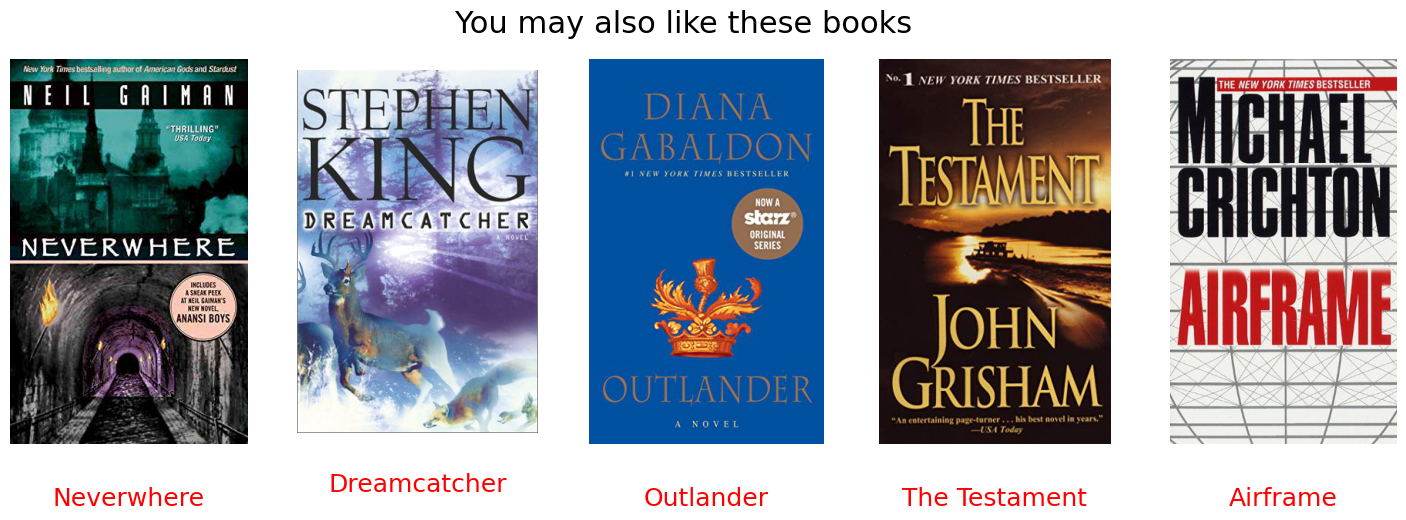

In [9]:
content_based_recommender('Wild Animus')



In [11]:
import pickle

In [12]:
with open('content_based_recommender.pkl', 'wb') as file:
    pickle.dump(content_based_recommender, file)



In [91]:
with open('df.pkl', 'wb') as file:
    pickle.dump(df, file)


In [9]:
def custom_recommender(book_title):
    # ITEM-BASED
    book_title = str(book_title)
    
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 180].index
        common_books = df[~df['book_title'].isin(rare_books)]

        if book_title in rare_books:
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try:\n')
            print('{}'.format(random[0]), '\n')
            print('{}'.format(random[1]), '\n')
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'], values='rating')
            book = user_book_df[book_title]
            recom_data = pd.DataFrame(user_book_df.corrwith(book). \
                                      sort_values(ascending=False)).reset_index(drop=False)

            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])

            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)

            if recom_data.shape[0] - len(low_rating) > 5:
                recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]

            recom_data = recom_data[0:1]
            recom_data.columns = ['book_title', 'corr']
            recommended_books = []
            for i in recom_data['book_title']:
                recommended_books.append(i)

            df_new = df[~df['book_title'].isin(recommended_books)]

            # CONTENT-BASED (Title, Author, Publisher, Category)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())

            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace=True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title', 'book_author', 'publisher', 'Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i, ].values) for i in
                                                 range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books, key=lambda x: x[1], reverse=True)[1:2]

            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())

            for i in books:
                recommended_books.append(i)

            df_new = df_new[~df_new['book_title'].isin(recommended_books)]

            # CONTENT-BASED (SUMMARY)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
            common_books = df_new[~df_new['book_title'].isin(rare_books)]

            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace=True)
            common_books['index'] = [i for i in range(common_books.shape[0])]

            summary_filtered = []
            for i in common_books['Summary']:
                i = re.sub("[^a-zA-Z]", " ", i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if not word in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)

            common_books['Summary'] = summary_filtered
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['Summary'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books2 = sorted(sim_books, key=lambda x: x[1], reverse=True)[1:4]
            sorted_sim_books = sorted_sim_books2[:2]
            summary_books = []
            for i in range(len(sorted_sim_books)):
                summary_books.append(
                    common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())

            for i in summary_books:
                recommended_books.append(i)

            df_new = df_new[~df_new['book_title'].isin(recommended_books)]

            # TOP RATED OF CATEGORY
            category = common_books[common_books['book_title'] == book_title]['Category'].values[0]
            top_rated = common_books[common_books['Category'] == category].groupby('book_title').agg(
                {'rating': 'mean'}).reset_index()

            if top_rated.shape[0] == 1:
                recommended_books.append(
                    common_books[common_books['index'] == sorted_sim_books2[2][0]]['book_title'].item())
            else:
                top_rated.drop(top_rated[top_rated['book_title'] == book_title].index[0], inplace=True)
                top_rated = top_rated.sort_values('rating', ascending=False).iloc[:1]['book_title'].values[0]
                recommended_books.append(top_rated)

            fig, axs = plt.subplots(1, 5, figsize=(18, 5))
            fig.suptitle('You may also like these books', size=22)
            for i in range(len(recommended_books)):
                url = df.loc[df['book_title'] == recommended_books[i], 'img_l'][:1].values[0]
                try:
                    opener = urllib.request.URLopener()
                    opener.addheader('User-Agent',
                                     'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36')
                    im = Image.open(opener.open(url))
                    axs[i].imshow(im)
                    axs[i].axis("off")
                    axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == recommended_books[i]]['rating'].mean(), 1)),
                                     y=-0.18,
                                     color="red",
                                     fontsize=18)
                except Exception as e:
                    print(f"Error opening image at URL: {url}")
                    print(traceback.format_exc())  # Print traceback for debugging
            plt.show()  # Display the plot

    else:
        print("Can't find book in the dataset, please check spelling")



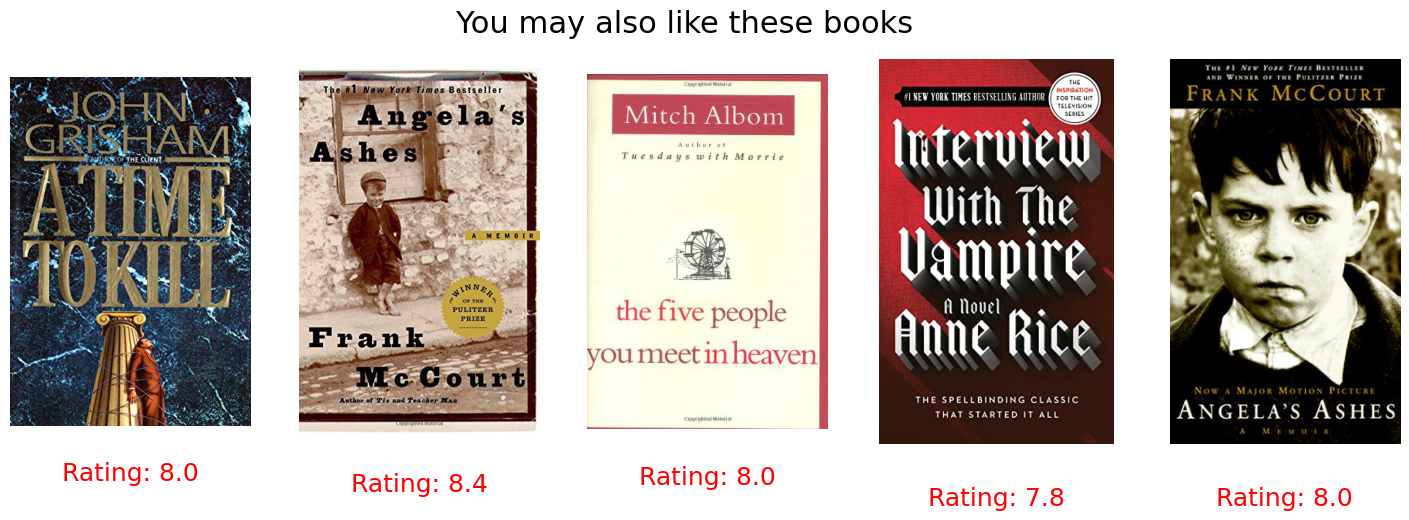

In [10]:
custom_recommender("Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson")


In [16]:
import nltk


In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Famitha
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [12]:
df['Category'].unique().shape

(4013,)

In [5]:
df.head(10)

,user_id,rating,book_title,book_author,publisher,img_l,Summary,Category
1,8,5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
4,67544,8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
7,123629,9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
9,200273,8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
10,210926,9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
11,219008,7,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
12,263325,6,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
14,2954,8,Decision in Normandy,Carlo D'Este,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,"Here, for the first time in paperback, is an o...",1940 1949
15,152827,7,Decision in Normandy,Carlo D'Este,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,"Here, for the first time in paperback, is an o...",1940 1949
17,35704,6,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,"Describes the great flu epidemic of 1918, an o...",Medical


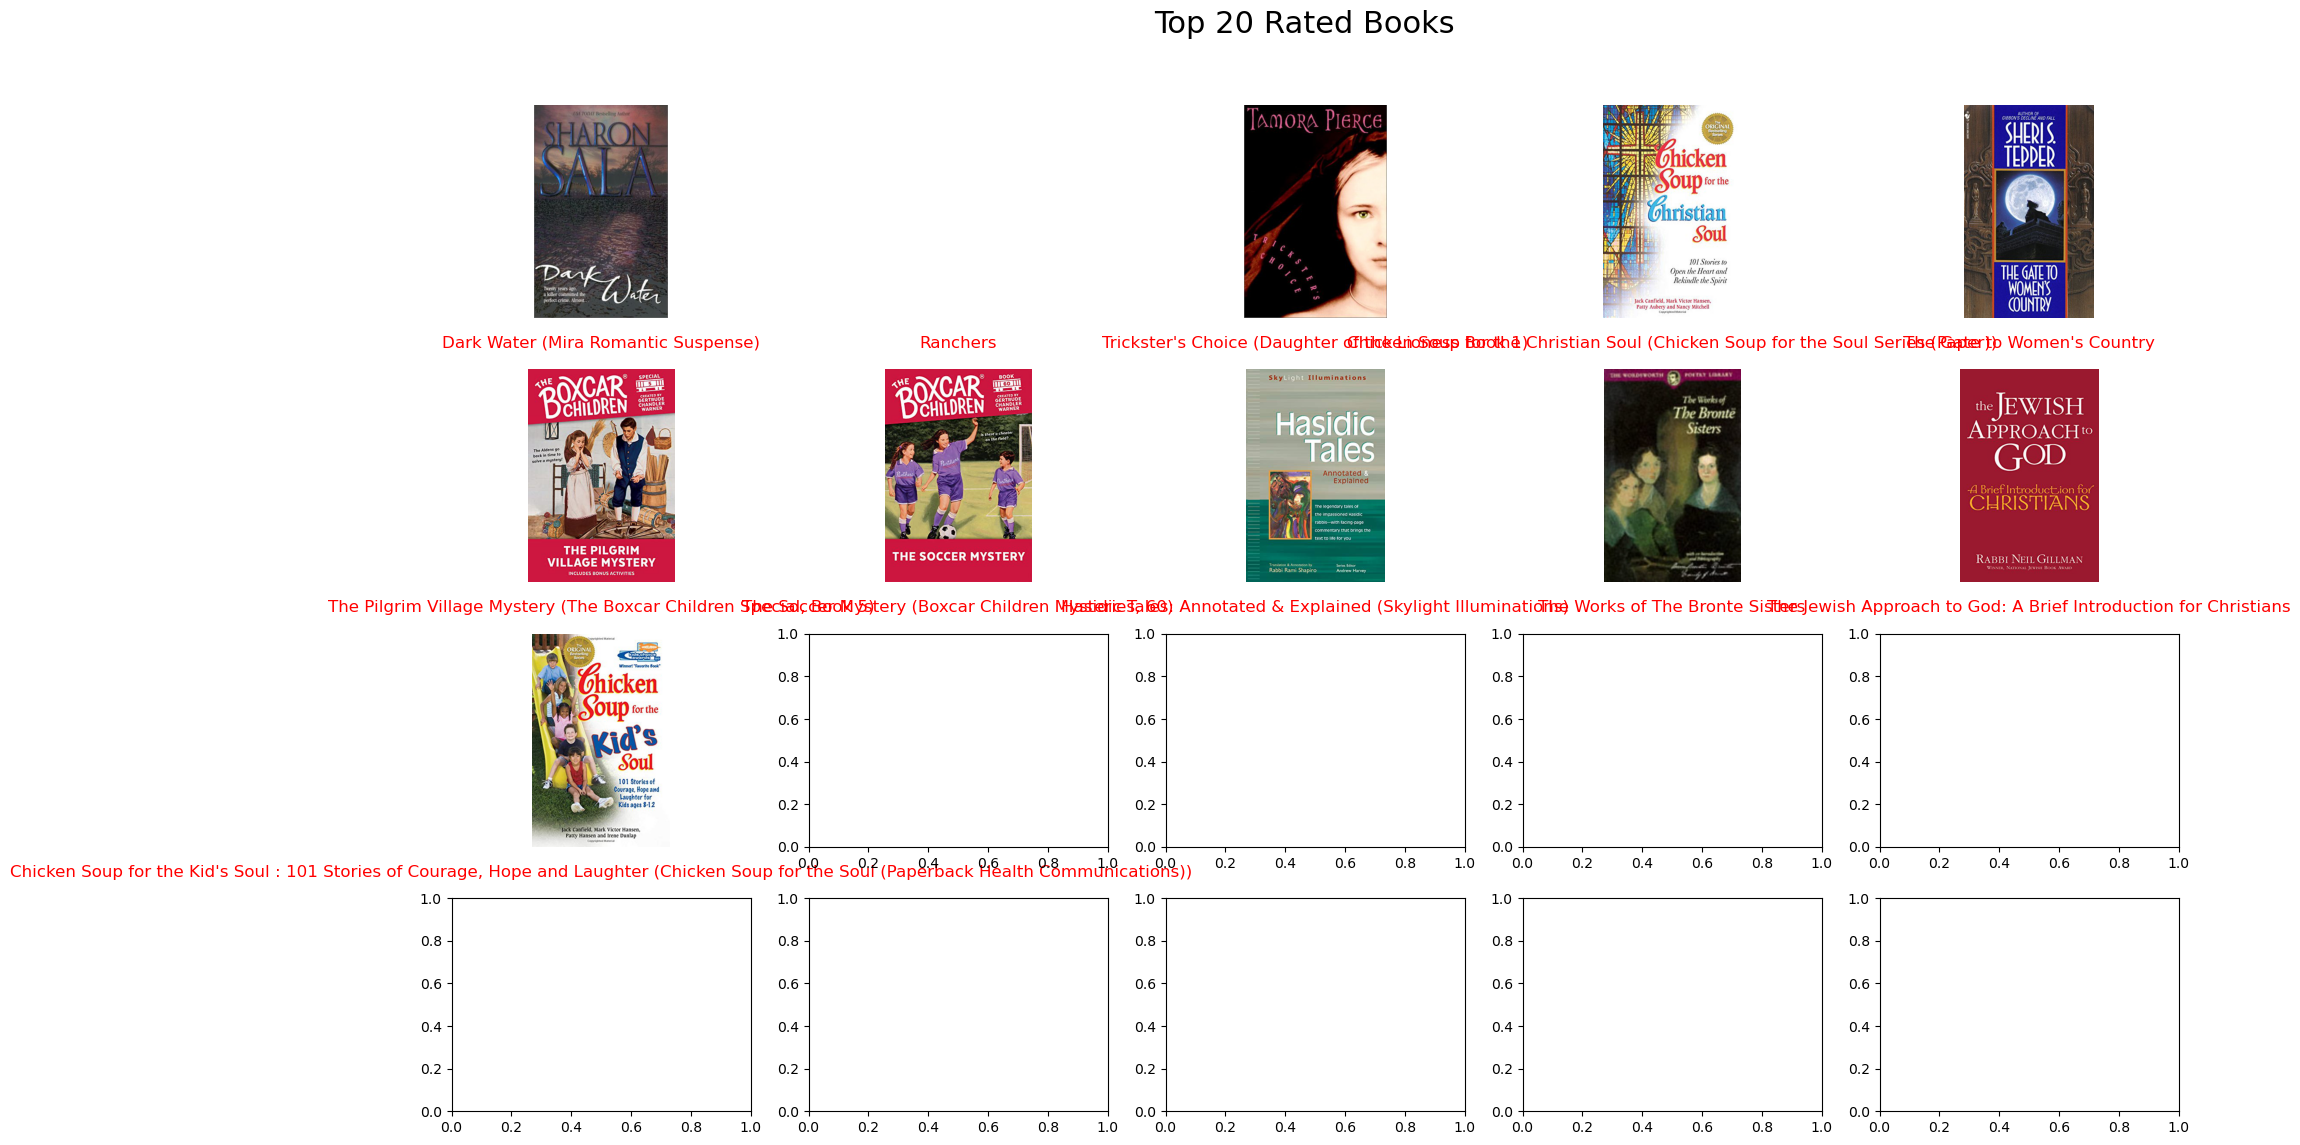

In [23]:
import pandas as pd
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt

# Define the function to get the top-rated books
def top_rated_books(df, n=20):
    # Sort the DataFrame by the 'rating' column in descending order
    top_rated_books = df.sort_values(by='rating', ascending=False)
    
    # Take the top 'n' books and drop any duplicates
    top_n_books = top_rated_books.head(n).drop_duplicates(subset='book_title')
    
    return top_n_books

# Call the function to get the top-rated 20 books
top_rated_books_20 = top_rated_books(df, n=20)

# Create a subplot for displaying book images and titles
fig, axs = plt.subplots(4, 5, figsize=(18, 12))
fig.suptitle('Top 20 Rated Books', size=22)

# Loop through the top-rated books and display their titles and cover images
for i, book in enumerate(top_rated_books_20.iterrows()):
    title = book[1]['book_title']
    img_url = book[1]['img_l']

    try:
        opener = urllib.request.URLopener()
        opener.addheader('User-Agent',
                         'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36')
        im = Image.open(opener.open(img_url))
        
        # Determine the position in the subplot
        row, col = divmod(i, 5)
        
        axs[row, col].imshow(im)
        axs[row, col].axis("off")
        axs[row, col].set_title(title, y=-0.18, color="red", fontsize=12)
    except Exception as e:
        print(f"Error opening image at URL: {img_url}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [7]:
df.shape

(217314, 8)

In [15]:
df2 = pd.DataFrame(df['book_title'].unique())

In [18]:
df2.shape

(73073, 1)

TypeError: missing a required argument: 'y_pred'